<a href="https://colab.research.google.com/github/gabrielcerono/GlioblastomaMultiforme/blob/main/Lammer2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The paper is found here: https://doi.org/10.1371/journal.pone.0221502https://doi.org/10.1371/journal.pone.0221502


The original dataset here: https://figshare.com/articles/dataset/Clinical_data_of_individual_patients_/14201600

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

In [2]:
dataset = pd.read_csv('/content/glioblastomadataset.csv')

In [3]:
dataset.head()

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
0,0,50,1,0,0,0,4.6
1,0,60,1,0,0,0,0.7
2,0,53,1,0,0,1,11.3
3,0,43,1,0,0,1,10.3
4,0,65,1,1,0,0,7.9


In [4]:
dataset.describe()

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.583333,56.983333,0.916667,0.383333,0.633333,0.400000,15.713333
std,0.497167,12.085138,0.278718,0.490301,0.485961,0.494032,11.745962
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.700000
25%,0.000000,50.750000,1.000000,0.000000,0.000000,0.000000,8.925000
50%,1.000000,58.000000,1.000000,0.000000,1.000000,0.000000,12.500000
75%,1.000000,65.250000,1.000000,1.000000,1.000000,1.000000,21.300000
max,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,52.400000


# First, we should make a quick data exploratory analysis.

In [5]:
import seaborn as sns

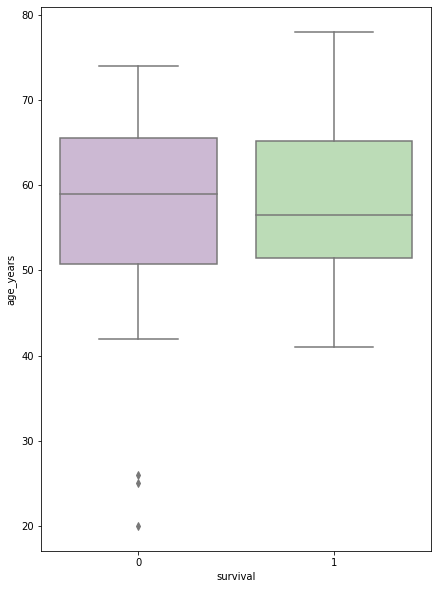

In [6]:
f,ax = plt.subplots(figsize =(7,10))
sns.boxplot(x="survival", y = 'age_years', data=dataset, palette="PRGn",ax=ax)
plt.show()

(0.0, 1.0)

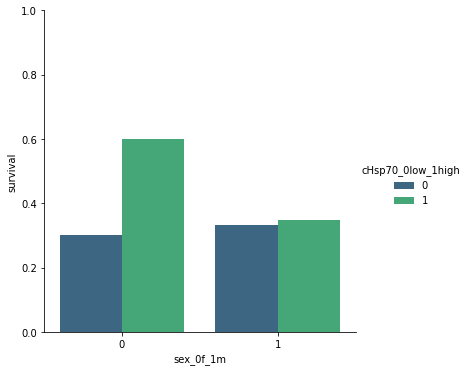

In [7]:
sns.catplot(x="sex_0f_1m", y="survival", hue="cHsp70_0low_1high", ci=None, palette='viridis', kind="bar", data=dataset)
plt.ylim(0, 1)

It seems that high levels cHsp70 increase survival rate only in females, something the original paper did not mention. We would have to look for covariates, and see if sex actually impact un survivality.

(0.0, 1.0)

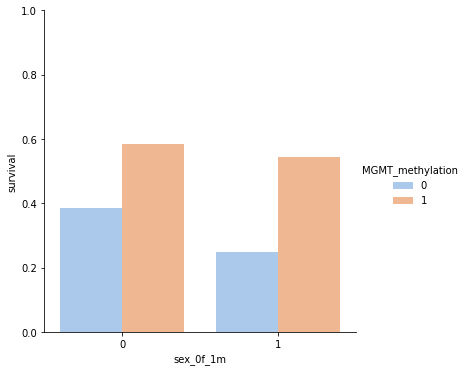

In [8]:
sns.catplot(x="sex_0f_1m", y="survival", hue="MGMT_methylation", kind="bar", palette="pastel", ci=None, data=dataset)
plt.ylim(0, 1)

(0.0, 1.0)

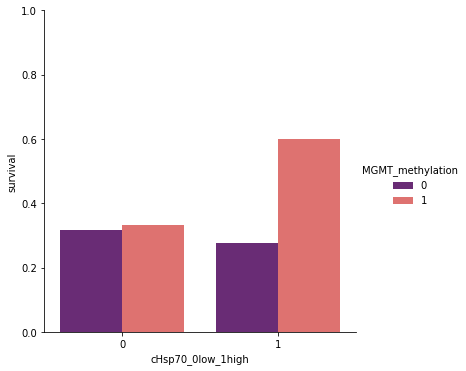

In [9]:
sns.catplot(x="cHsp70_0low_1high", y="survival", hue="MGMT_methylation", kind="bar", ci=None,  palette="magma", data=dataset)
plt.ylim(0, 1)

It seems like MGMT methylation has a permissive effect on ChSp. The original paper did arrived to this conclusion. 

(0.0, 1.2)

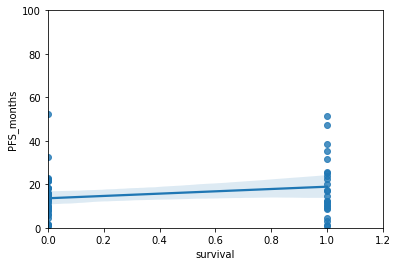

In [10]:
sns.regplot(x="survival", y="PFS_months", data=dataset)
plt.ylim(0, 100)
plt.xlim(0, 1.2)

In [11]:
dataset.corr(method='pearson')

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high,survival,PFS_months
sex_0f_1m,1.000000,-0.269165,-0.010193,-0.168035,0.058461,-0.138013,0.039569
age_years,-0.269165,1.000000,-0.161440,0.118375,0.079750,0.080623,0.177742
did_progress,-0.010193,-0.161440,1.000000,-0.010336,-0.229416,-0.369274,-0.456801
MGMT_methylation,-0.168035,0.118375,-0.010336,1.000000,0.386500,0.265897,0.320183
cHsp70_0low_1high,0.058461,0.079750,-0.229416,0.386500,1.000000,0.127076,0.328388
survival,-0.138013,0.080623,-0.369274,0.265897,0.127076,1.000000,0.223676
PFS_months,0.039569,0.177742,-0.456801,0.320183,0.328388,0.223676,1.000000


# First Analysis


First we want to divide the dataset in 3 sections:

1.   Train set
2.   Ranking feature set
3.   Test



In [12]:
X = dataset.drop(columns=['survival', 'PFS_months'], axis = 1)
y = dataset['survival']

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

In [16]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
y_pred = clf.predict(X_test)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.4500


In [18]:
matthews_corrcoef(y_test, y_pred)

0.022875450543583874

In [19]:
matthews = ()

In [23]:
features = []
matthew = []
f1score = []
accuracy = []
ppv = []
npv = []

for x in range(10):
  seed = np.random.randint(10000)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
  X_train, X_rank, y_train, y_rank = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  #Numpy array of X.columns dimensions. We vertical stack it, so we get one column. 
  featuresInside = np.vstack(clf.feature_importances_)
  #We pass the numpy array to Pandas Dataframe, so we can rank it. 
  featuresdf = pd.DataFrame(data = featuresInside, columns = ['features'])
  #We rank the features
  featuresdf['ranking'] = featuresdf['features'].rank(ascending = 0)
  #We convert back the ranking to numpy array
  featuresnp = featuresdf['ranking'].to_numpy()
  #We will add the numpy array to the list
  features.append(featuresnp)

features = np.array(features)
featurestotal = features.sum(axis=0)
featuremean = features.mean(axis = 0)
featuresd = features.std(axis = 0)
featuresname = X.columns
feature_by_ranking = np.dstack((featurestotal, featuremean, featuresd, featuresname))
feature_by_ranking = feature_by_ranking.reshape(5, 4)
finalranking = pd.DataFrame(data = feature_by_ranking, columns= ['Borda Total', 'Borda Average', 'Borda Standard Deviation', 'Feature'])
finalranking.sort_values(by = ['Borda Average'], ascending = 1, inplace = True)

In [24]:
finalranking

,Borda Total,Borda Average,Borda Standard Deviation,Feature
1,10,1,0,age_years
0,31,3.1,0.7,sex_0f_1m
3,32,3.2,0.87178,MGMT_methylation
4,35,3.5,1.20416,cHsp70_0low_1high
2,42,4.2,1.249,did_progress


In [25]:
featuresd

array([0.7       , 0.        , 1.2489996 , 0.87177979, 1.20415946])

In [27]:
loco = clf.feature_importances_
loco

array([0.13516639, 0.52134501, 0.05201522, 0.20501019, 0.08646319])

In [28]:
np.vstack(loco)

array([[0.13516639],
       [0.52134501],
       [0.05201522],
       [0.20501019],
       [0.08646319]])

In [29]:
prueba1 = pd.DataFrame(data = features, columns= X.columns )
prueba1

,sex_0f_1m,age_years,did_progress,MGMT_methylation,cHsp70_0low_1high
0,4.0,1.0,2.0,3.0,5.0
1,3.0,1.0,2.0,4.0,5.0
2,3.0,1.0,5.0,4.0,2.0
3,3.0,1.0,5.0,4.0,2.0
4,4.0,1.0,5.0,3.0,2.0
5,4.0,1.0,5.0,2.0,3.0
6,2.0,1.0,5.0,4.0,3.0
7,3.0,1.0,5.0,2.0,4.0
8,2.0,1.0,3.0,4.0,5.0
9,3.0,1.0,5.0,2.0,4.0


In [30]:
prueba1["sex_0f_1m"].to_numpy()

array([4., 3., 3., 3., 4., 4., 2., 3., 2., 3.])

## RFE with Matthew score

In [34]:
import RFE_Glioblastoma as rfe

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [35]:
ranking = rfe.RankingRE(X, y, 100, clf)

In [36]:
rank, score = ranking.ranking_by_matthew_punishment()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [37]:
rank

,Categories,average-mtt-punishment,ranking,SD_of_matt_punishment
2,did_progress,0.04264286264937213,1.0,0.167728563744348
3,MGMT_methylation,0.029112349228890066,2.0,0.17599907178711663
1,age_years,-0.07673179329790314,3.0,0.20829247443019802
4,cHsp70_0low_1high,-0.011113645032262465,4.0,0.2029815339658201
0,sex_0f_1m,-0.009464106266606535,5.0,0.1864670581167237


In [38]:
score # Is the matthew mean

0.29012942659282975